In [1]:
import pandas as pd
import numpy as np
import os
import gzip, pickle
import re
import cycler

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Leitura do banco

In [2]:
data_dir = "./"
db_file = 'fundos.db'
engine = create_engine("sqlite:///"+os.path.abspath(os.path.join(data_dir, db_file)))

data_inicio = '2009-02-26'
data_fim = '2017-12-31'
cnpj_fundo = '12.055.107/0001-16' #ALASK BLACK

In [3]:
#cotas
sqlquery = """
select VL_QUOTA, DT_COMPTC from inf_diario
where CNPJ_FUNDO = '{cnpj_fundo}'
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundo=cnpj_fundo, data_inicio=data_inicio, data_fim=data_fim)
cotas = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC']).set_index("DT_COMPTC")['VL_QUOTA'].sort_index()

In [49]:
#carteira e pesos
sqlquery = """
select * from cda
where CNPJ_FUNDO = '{cnpj_fundo}'
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundo=cnpj_fundo, data_inicio=data_inicio, data_fim=data_fim)
carteira = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC'])
pl = carteira.sort_values(['DT_COMPTC', 'FILE'])['VL_PATRIM_LIQ'].fillna(method='bfill')
carteira['VL_PATRIM_LIQ'] = pl
carteira['peso'] = carteira['VL_MERC_POS_FINAL'].div(carteira['VL_PATRIM_LIQ'])

#Valores a pagar são negativos
q = carteira.TP_APLIC == 'Valores a pagar'
carteira.loc[q, ['VL_MERC_POS_FINAL', 'peso']] *= -1

pivot_cols = carteira.CD_ATIVO\
            .fillna(carteira.CD_ISIN)\
            .fillna(carteira[carteira.FILE.str.contains('BLC_8') & carteira.TP_ATIVO.str.contains("Ação|Ações|Opção|Opcões|Outr|Recibo|BDR", flags=re.IGNORECASE)].DS_ATIVO.str.extract(r'([A-Z]{0,5}\d+)', expand=False))\
            .fillna(carteira[carteira.FILE.str.contains('BLC_8')].DS_ATIVO.str.extract(r'(BR[A-Z0-9]+)', expand=False))\
            .fillna(carteira[carteira.DS_ATIVO.str.lower().isin(['disponibilidades', 'valores a pagar', 'valores a receber'])].DS_ATIVO.str.upper()) \
            .fillna(carteira[carteira.TP_ATIVO == 'Título público federal'].DS_ATIVO.str.extract(r'(\d{6})', expand=False))\
            .fillna(carteira.CNPJ_FUNDO_COTA)\
            .fillna(carteira.DS_INDEXADOR_POSFX)\
            .fillna(carteira.CD_ATIVO_BV_MERC)\
            .fillna(carteira.TP_APLIC)
pesos = carteira.pivot_table(index='DT_COMPTC', columns=pivot_cols, values='peso', aggfunc='sum')

In [51]:
#acoes
sqlquery = """
select * from cotacoes
WHERE CODNEG in ('{ativos}')
and DATA >= '{data_inicio}'
and DATA <= '{data_fim}'
""".format(ativos="','".join(pesos.columns), data_inicio=data_inicio, data_fim=data_fim)
acoes_qry = pd.read_sql_query(sqlquery, engine, parse_dates=['DATA'])

In [52]:
### Titulos
sqlquery = """
select * from titulos_publicos
WHERE CODISI in ('{ativos}')
OR CODIGO in ('{ativos}')
and DT_MOV >= '{data_inicio}'
and DT_MOV <= '{data_fim}'
""".format(ativos="','".join(pesos.columns), data_inicio=data_inicio, data_fim=data_fim)
titulos_qry = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_MOV'])

In [53]:
## Futuros
sqlquery = """
select DATE as DT_MOV, substr(MERCADORIA,0,4) || '_' || VENCIMENTO as CODIGO, PRECO_ATUAL/PRECO_ANTERIOR - 1 as PCT_CHANGE, VARIACAO, PRECO_ATUAL from futuros
WHERE DT_MOV >= '{data_inicio}'
and DT_MOV <= '{data_fim}'
and MERCADORIA = 'IND - Ibovespa'
""".format(data_inicio=data_inicio, data_fim=data_fim)
futuros_qry = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_MOV'])#.pivot_table(index='DT_MOV', columns='CODIGO', values='PCT_CHANGE').groupby(dict(futuros_carteira), axis=1).mean()
futuros_qry[['MERCADORIA','MES_VENCIMENTO', 'ANO_VENCIMENTO']] = futuros_qry.CODIGO.str.extract(r"(.*)_(.)(..)")

# Calcula os retornos dos ativos e dos títulos

In [54]:
retornos_acoes = acoes_qry.query("TPMERC == 10").pivot_table(index='DATA', columns='CODNEG', values='PREULT').div(100).pct_change()
retornos_titulos = titulos_qry.pivot_table(index='DT_MOV', columns='CODISI', values='VALOR_PAR').pct_change()
retornos_opcoes = acoes_qry.query("TPMERC != 10").pivot_table(index='DATA', columns='CODNEG', values='PREULT').div(100).pct_change()

## Análise PCA dos retornos dos ativos

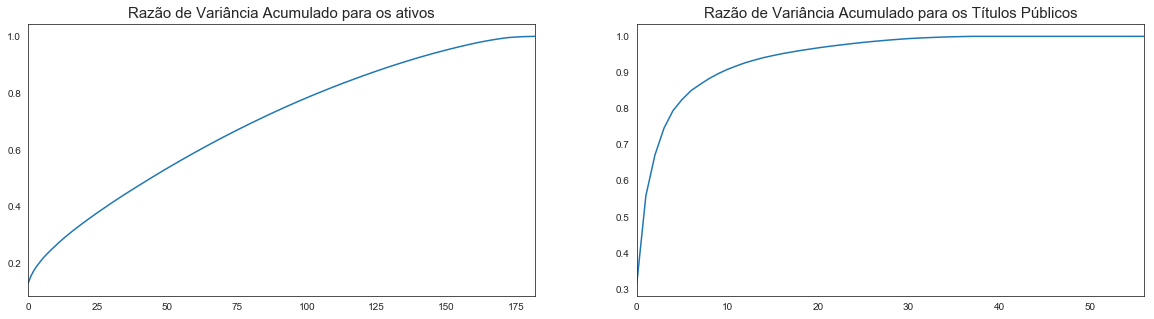

In [55]:
fig, (axe, axd) = plt.subplots(ncols=2, figsize=(20,5))
std_stock_returns = StandardScaler().fit_transform(retornos_acoes.fillna(0))
pd.Series(PCA().fit(std_stock_returns).explained_variance_ratio_).cumsum().plot(ax=axe)
axe.set_title('Razão de Variância Acumulado para os ativos', fontsize=15)

std_securities_returns = StandardScaler().fit_transform(retornos_titulos.fillna(0))
pd.Series(PCA().fit(std_securities_returns).explained_variance_ratio_).cumsum().plot(ax=axd)
axd.set_title('Razão de Variância Acumulado para os Títulos Públicos', fontsize=15);

## Cria uma proxy para o índice futuro

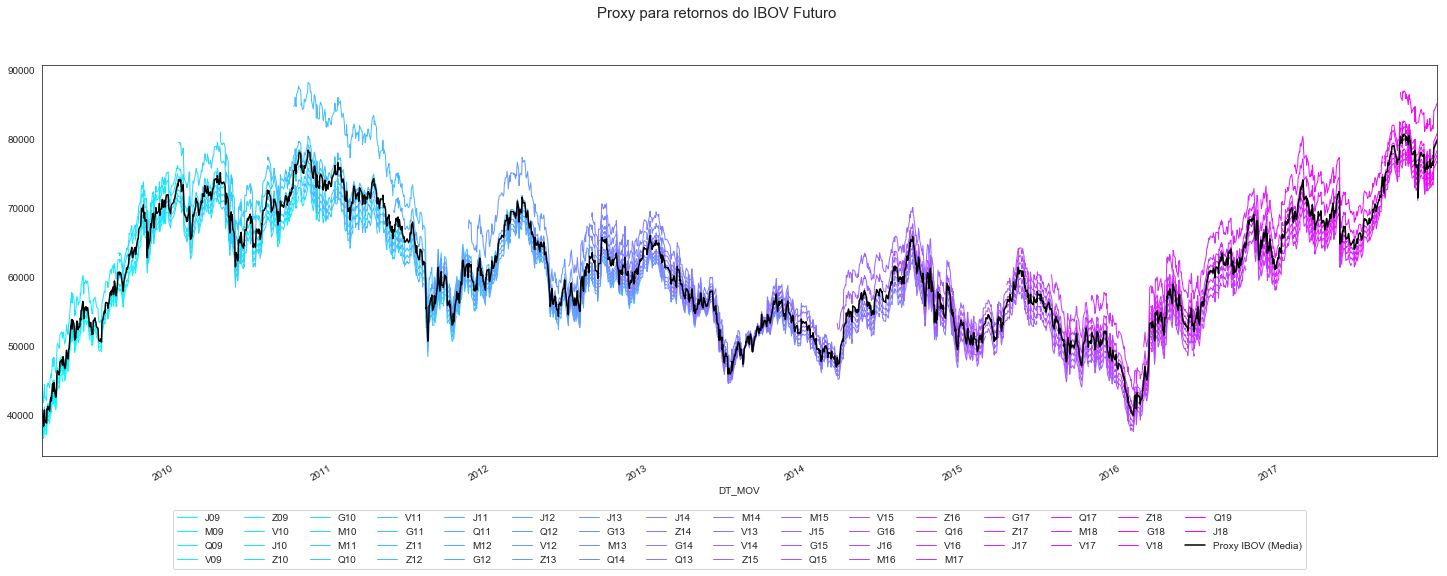

In [56]:
q = futuros_qry.MERCADORIA.str.contains('IND')
grp = futuros_qry.loc[q].groupby(['DT_MOV','ANO_VENCIMENTO','MES_VENCIMENTO'])['PRECO_ATUAL']
df = grp.mean().unstack([2,1])
df.columns = [i+j for i, j in df.columns]
df.plot(figsize=(25,8), cmap='cool', lw=1)
IBOV_FUT = grp.mean().groupby(level='DT_MOV').mean().rename('IBOV_FUT')
IBOV_FUT.plot(color='k', label='Proxy IBOV (Media)', ls='-')
plt.legend(ncol=16, loc=8, bbox_to_anchor=(0.5,-0.3))
plt.suptitle("Proxy para retornos do IBOV Futuro",fontsize=15);

# Ajustes manuais

## Agrupamento de preferenciais e ordinarias

In [11]:
retornos_acoes_empresa = retornos_acoes.groupby(lambda s: s[0:4], axis=1)

In [12]:
retornos_acoes_empresa = retornos_acoes.groupby(lambda s: s[0:4], axis=1).mean()
retornos_acoes_empresa['PCAR'] = retornos_acoes['PCAR4'].replace(0,pd.np.nan).fillna(retornos_acoes['PCAR5']).values
#retornos_acoes_empresa['CMIG'] = retornos_acoes[['CMIG3','CMIG4']].mean(axis=1).values
#retornos_acoes_empresa['SEER'] = retornos_acoes['SEER3'].values
retornos_acoes_empresa['BTOW'] = retornos_acoes['BTOW3'].values
retornos_acoes_empresa['MULT'] = retornos_acoes['MULT3'].values
retornos_acoes_empresa['ITSA'] = retornos_acoes['ITSA4'].values
retornos_acoes_empresa['BBDC'] = retornos_acoes['BBDC4'].values
retornos_acoes_empresa['ABEV'] = retornos_acoes['ABEV3'].values
retornos_acoes_empresa['HRTP'] = retornos_acoes['HRTP3'].values
retornos_acoes_empresa['KLBN'] = retornos_acoes['KLBN4'].values
retornos_acoes_empresa['LPSB'] = retornos_acoes['LPSB3'].values
retornos_acoes_empresa['SAPR'] = retornos_acoes['SAPR4'].values
retornos_acoes_empresa['MPXE'] = retornos_acoes['MPXE3'].values
retornos_acoes_empresa['GFSA'] = retornos_acoes['GFSA3'].values
retornos_acoes_empresa['GFSA'] = retornos_acoes['GFSA3'].values
#retornos_acoes_empresa['LAME'] = retornos_acoes['LAME3'].values
retornos_acoes_empresa['HYPE'] = retornos_acoes['HYPE3'].values
retornos_acoes_empresa['KROT'] = retornos_acoes['KROT11'].replace(0,pd.np.nan).fillna(retornos_acoes['KROT3'].rolling(3).median()).values
retornos_acoes_empresa['SUZB'] = retornos_acoes['SUZB5'].replace(0,pd.np.nan).fillna(retornos_acoes['SUZB3']).values
retornos_acoes_empresa['VALE'] = retornos_acoes[['VALE3','VALE5']].mean(axis=1).values
#retornos_acoes_empresa['GETI'] = retornos_acoes[['GETI3','GETI4']].mean(axis=1).values
retornos_acoes_empresa['PETR'] = retornos_acoes[['PETR3','PETR4']].mean(axis=1).values
#retornos_acoes_empresa['AEDU'] = retornos_acoes['AEDU11'].replace(0,pd.np.nan).fillna(retornos_acoes['AEDU3']).values
retornos_acoes_empresa['RAPT'] = retornos_acoes['RAPT4'].values

In [13]:
agrupamentos = retornos_acoes.groupby(lambda s: s[0:4], axis=1).count().max()
agrupamentos = agrupamentos[agrupamentos }> 1].sort_values()
agrupamentos[~agrupamentos.index.isin(retornos_acoes_empresa.columns)]

Series([], dtype: int64)

In [14]:
#adiciona os pesos agregados dos contratos futuros na matriz de pesos
q = pivot_cols.isnull() & carteira.DS_ATIVO.str.contains('IND')
pesos['IBOV_FUT'] = carteira.loc[q].groupby('DT_COMPTC')['peso'].sum().reindex(index=pesos.index)

In [15]:
#ajusta os títulos que foram listados apenas com a selic no bloco_8 do relatório à CVM
cod_selic_codigo_ISI_map = dict(titulos_qry[['CODIGO', 'CODISI']].drop_duplicates().applymap(str).values)
pesos.rename(columns=cod_selic_codigo_ISI_map, inplace=True)

In [16]:
ticker_empresa_map = {v:k for k,vv in retornos_acoes.groupby(lambda s: s[0:4], axis=1).groups.items() for v in vv}
ticker_empresa_map.update({'TEND9':'TEND'})
pesos.rename(columns=ticker_empresa_map, inplace=True)

In [17]:
#ativos não identificados
retornos = pd.concat([retornos_acoes_empresa, retornos_titulos,retornos_opcoes, IBOV_FUT.pct_change().to_frame()], sort=False, axis=1).drop_duplicates()
identified = list(retornos.columns.str.lower()) + ['disponibilidades','valores a pagar','valores a receber']
print((~pesos.columns.str.lower().isin(identified)).sum(), 'ativos sem retornos correspondentes identificados')
pesos.loc[:,~pesos.columns.str.lower().isin(identified)].columns

22 ativos sem retornos correspondentes identificados


Index(['09.215.250/0001-13', 'BRAER', 'BRAS', 'BRASKEM', 'BRIA',
       'DI de um dia', 'LOGN9', 'LVMGD3', 'LVMGF0', 'LVUJF9',
       'Mercado Futuro - Posições compradas',
       'Mercado Futuro - Posições vendidas', 'OLCNG8', 'OLCNJ89', 'OLCQG8',
       'OLCQG84', 'OLCUJ9', 'Opções - Posições lançadas',
       'Opções - Posições titulares', 'Outras aplicações',
       'Outros valores mobiliários registrados na CVM objeto de oferta pública',
       'PCARD06'],
      dtype='object', name='CD_ATIVO')

In [18]:
pesos = pesos.groupby(level=0, axis=1).sum()

## Agrupamento das ações por classe e agrupamento dos pesos

In [19]:
import colorlover as cl

In [20]:
classes = pd.read_excel("classificao_acoes.xlsx", encoding='latin1')
classes.columns = ['SETOR','SUBSETOR','SEGMENTO','EMPRESA','CODIGO','SEGMENTO.1']
classes_acoes = dict(classes[['CODIGO','SETOR']].values)

In [21]:
mapper = dict(zip(retornos_acoes.columns, retornos_acoes.columns.str.slice(0,4).map(classes_acoes.get)))

In [22]:
pesos_acoes = pesos.groupby(classes_acoes.get, axis=1).sum()
pesos_titulos = pd.Series(pesos.reindex(columns=retornos_titulos.columns).sum(axis=1), name='Títulos Públicos')
pesos_opcoes = pd.Series(pesos.reindex(columns=retornos_opcoes.columns).sum(axis=1), name='Opções')
outros_pesos = pesos[['VALORES A PAGAR', 'VALORES A RECEBER','DISPONIBILIDADES','IBOV_FUT']]

In [23]:
pesos.loc['2011-09-30'].replace(0,pd.np.nan).dropna()
carteira.query("DT_COMPTC == '2011-09-30'")

,Id,AG_RISCO,BV_MERC,CD_ATIVO,CD_ATIVO_BV_MERC,CD_BV_MERC,CD_INDEXADOR_POSFX,CD_ISIN,CD_PAIS,CD_SELIC,...,TP_NEGOC,TP_TITPUB,FILE,VL_AQUIS_NEGOC,VL_ATIVO_EXTERIOR,VL_CUSTO_POS_FINAL,VL_MERC_POS_FINAL,VL_PATRIM_LIQ,VL_VENDA_NEGOC,peso
35,1348638,None,None,None,None,None,None,BRSTNCNTB393,None,760199,...,Para negociação,NOTAS DO TESOURO NACIONAL SERIE B,BLC_1,NaN,None,None,7.387218e+05,3938703.75,NaN,0.187555
36,1348639,None,None,None,None,None,None,BRSTNCLF1QT0,None,210100,...,Para negociação,LETRAS FINANCEIRAS DO TESOURO,BLC_1,0.0,None,None,6.845396e+05,3938703.75,0.0,0.173798
463,14624259,None,None,BBAS3,None,None,None,BRBBASACNOR3,None,None,...,Para negociação,None,BLC_4,0.0,None,None,1.662790e+05,3938703.75,0.0,0.042217
464,14624260,None,None,BRML3,None,None,None,BRBRMLACNOR9,None,None,...,Para negociação,None,BLC_4,0.0,None,None,8.260300e+04,3938703.75,0.0,0.020972
465,14624261,None,None,BRPR3,None,None,None,BRBRPRACNOR9,None,None,...,Para negociação,None,BLC_4,0.0,None,None,1.737036e+05,3938703.75,0.0,0.044102
466,14624262,None,None,BTOW3,None,None,None,BRBTOWACNOR8,None,None,...,Para negociação,None,BLC_4,0.0,None,None,1.323000e+04,3938703.75,0.0,0.003359
467,14624263,None,None,BVMF3,None,None,None,BRBVMFACNOR3,None,None,...,Para negociação,None,BLC_4,0.0,None,None,7.954950e+04,3938703.75,0.0,0.020197
468,14624264,None,None,CSNA3,None,None,None,BRCSNAACNOR6,None,None,...,Para negociação,None,BLC_4,0.0,None,None,7.970400e+04,3938703.75,0.0,0.020236
469,14624265,None,None,CYRE3,None,None,None,BRCYREACNOR7,None,None,...,Para negociação,None,BLC_4,0.0,None,None,8.255550e+04,3938703.75,0.0,0.020960
470,14624266,None,None,GSHP3,None,None,None,BRGSHPACNOR7,None,None,...,Para negociação,None,BLC_4,0.0,None,None,3.405000e+04,3938703.75,0.0,0.008645


In [24]:
pesos_agregados = pd.concat([pesos_acoes,pesos_titulos,pesos_opcoes,outros_pesos], axis=1)

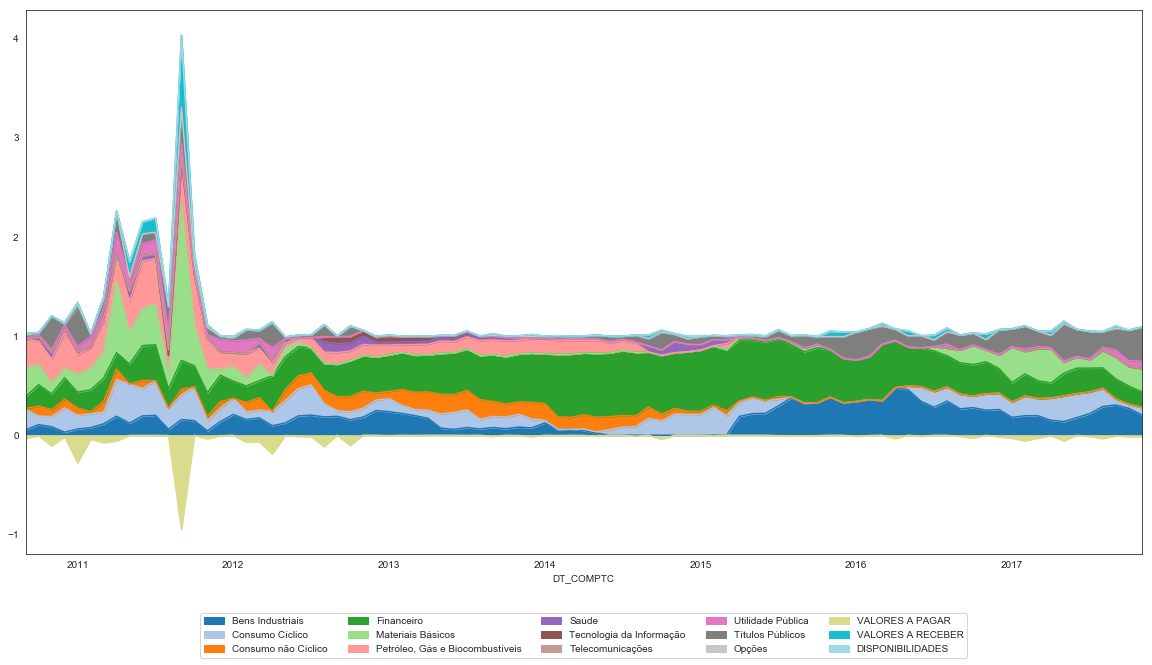

In [25]:
ax = pesos_agregados.drop('IBOV_FUT',axis=1).plot.area(figsize=(20,10), cmap='tab20')
ax.legend(ncol=5, loc=8, bbox_to_anchor=(0.5,-0.2))

In [46]:
#ax = pesos.drop('IBOV_FUT',axis=1).plot.area(figsize=(20,10))
#ax.legend(ncol=10, loc=8, bbox_to_anchor=(0.5,-0.8))

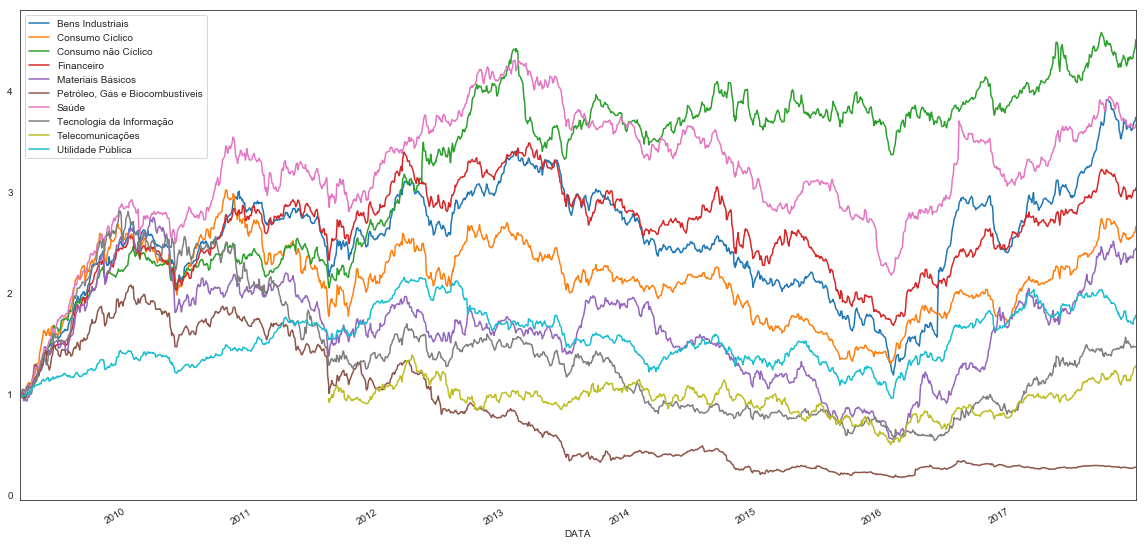

In [27]:
grp = retornos_acoes_empresa.groupby(classes_acoes.get, axis=1)
grp.mean().rolling(3).median().add(1).cumprod().plot(figsize=(20,10))

### Verifica se os dados contemplam todos ativos da carteira e se os pesos somam 1


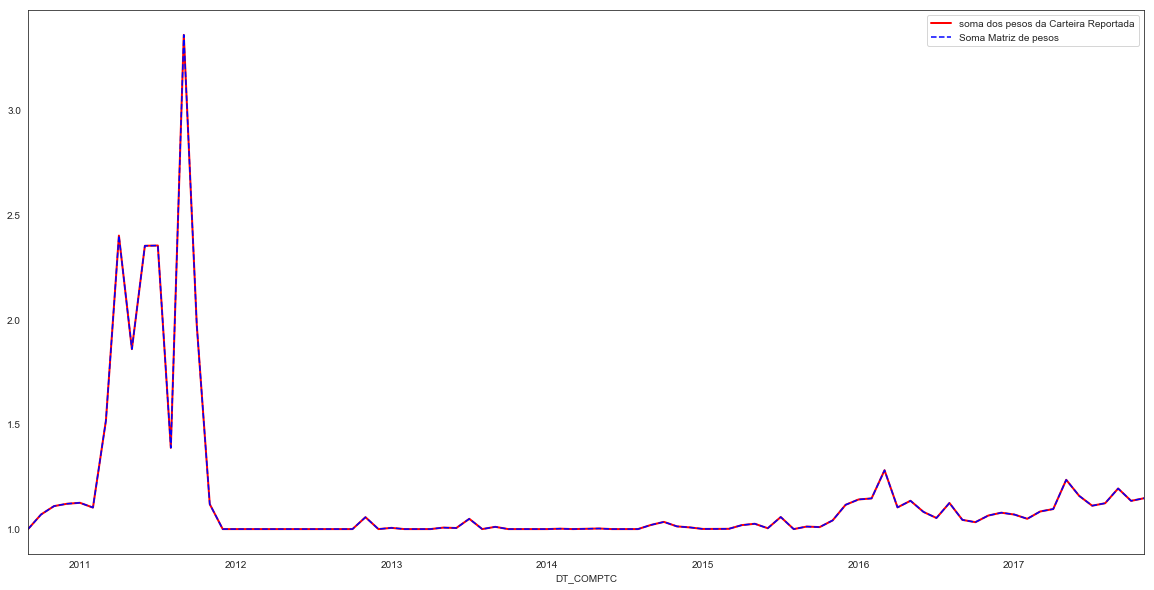

In [28]:
#os ativos somam 1 todos os meses?
q = carteira.groupby('DT_COMPTC').peso.sum()
ax = q.plot(figsize=(20,10), label='soma dos pesos da Carteira Reportada', color='red', lw=2)
pesos.sum(axis=1).plot(ax=ax, color='blue', ls='--', label='Soma Matriz de pesos')
#porque em 31/01/2013 o peso soma só 0.85? Faltam 7MM de patrimônio líquido. operações compromissadas?
ax.legend()

# Filtro de Kalman
2 passos

In [29]:
retornos_agregados = pd.concat([
        retornos_acoes_empresa.groupby(classes_acoes.get, axis=1).mean(),
        pd.Series(retornos_titulos.mean(axis=1), name='Títulos Públicos'),
        pd.Series(0, index=retornos_titulos.index, name='Caixa')
    ], axis=1)

pesos_agregados = pd.concat([
    pesos_acoes,
    pesos_titulos,
    pd.Series(outros_pesos[['VALORES A PAGAR', 'VALORES A RECEBER']].sum(1), name='Caixa')
], axis=1)

In [30]:
#Tratamento de outliers
q = retornos_agregados < retornos_agregados.std()*3
retornos_agregados = retornos_agregados[q].fillna(retornos_agregados.rolling(3, center=True).median())

In [31]:
#variacão da cota 
measurements = ((cotas - cotas.shift())/cotas).dropna()
measurements = measurements.reindex(index=measurements.index.intersection(pd.date_range(pesos.index.min(), pesos.index.max())))

#estados
eom_pesos = pesos_agregados.resample('D').bfill().reindex(index=measurements.index).reindex(index=measurements.groupby(pd.Grouper(freq='M')).tail(1).index)
states = eom_pesos.reindex(columns=retornos_agregados.columns, index=measurements.index)

signals = retornos_agregados.reindex(index=measurements.index.values).fillna(method='pad')

In [32]:
#correlação de não se fazer nada
states.fillna(method='pad').mul(signals).sum(axis=1).corr(measurements)

0.5269680870882326

In [33]:
n_dim = len(states.columns)

from filterpy.kalman import KalmanFilter
from filterpy.common import Saver, inv_diagonal
import tqdm

kf = KalmanFilter(n_dim,2+ n_dim)
kf.F *= 1
kf.Q *= np.sqrt(0.005)#0.31#2500


kf.x = eom_pesos.iloc[0].fillna(0).values
kf.P = np.zeros(kf.dim_x)


s = Saver(kf)
Hs = []
Rs = []
Zs = []
epss = []
for i,dt in tqdm.tqdm_notebook(enumerate(measurements.index), total=len(measurements)):
    
    if dt in eom_pesos.index:
        H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,kf.dim_x), np.eye(kf.dim_x), np.ones(kf.dim_x)])
        R = np.eye(kf.dim_z) * 0.3
    else:
        H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,kf.dim_x),  np.eye(kf.dim_x)*0, np.ones(kf.dim_x)]).astype(float)
        R = np.eye(kf.dim_z) * 0.3
        R[0,0] = 0.0008
        R[-1,-1] = 0.00000001
 

    Z = np.hstack([measurements.loc[dt], states.loc[dt].fillna(0), 1])
    
    kf.H = H
    kf.R = R
    #kf.F = np.diag((1-H[0]).reshape(kf.dim_x))
    
    kf.predict()
    kf.update(Z)
    
    y, S = kf.y[[0]], kf.S[0,0].reshape(1,1)
    eps = np.dot(y.T, np.linalg.inv(S)).dot(y)
    
    epss.append(eps)
    
    s.save()

s.to_array()

estimativas = pd.DataFrame(s.x, index=measurements.index, columns=signals.columns)
(estimativas * signals).sum(axis=1).corr(measurements)

0.9266956322174495

In [34]:
from filterpy.kalman import rts_smoother
## Calcula as matrizes smoothed
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

smooth = pd.DataFrame(sx, index=measurements.index, columns=signals.columns)
(smooth * signals).sum(axis=1).corr(measurements)

0.8938873156530384

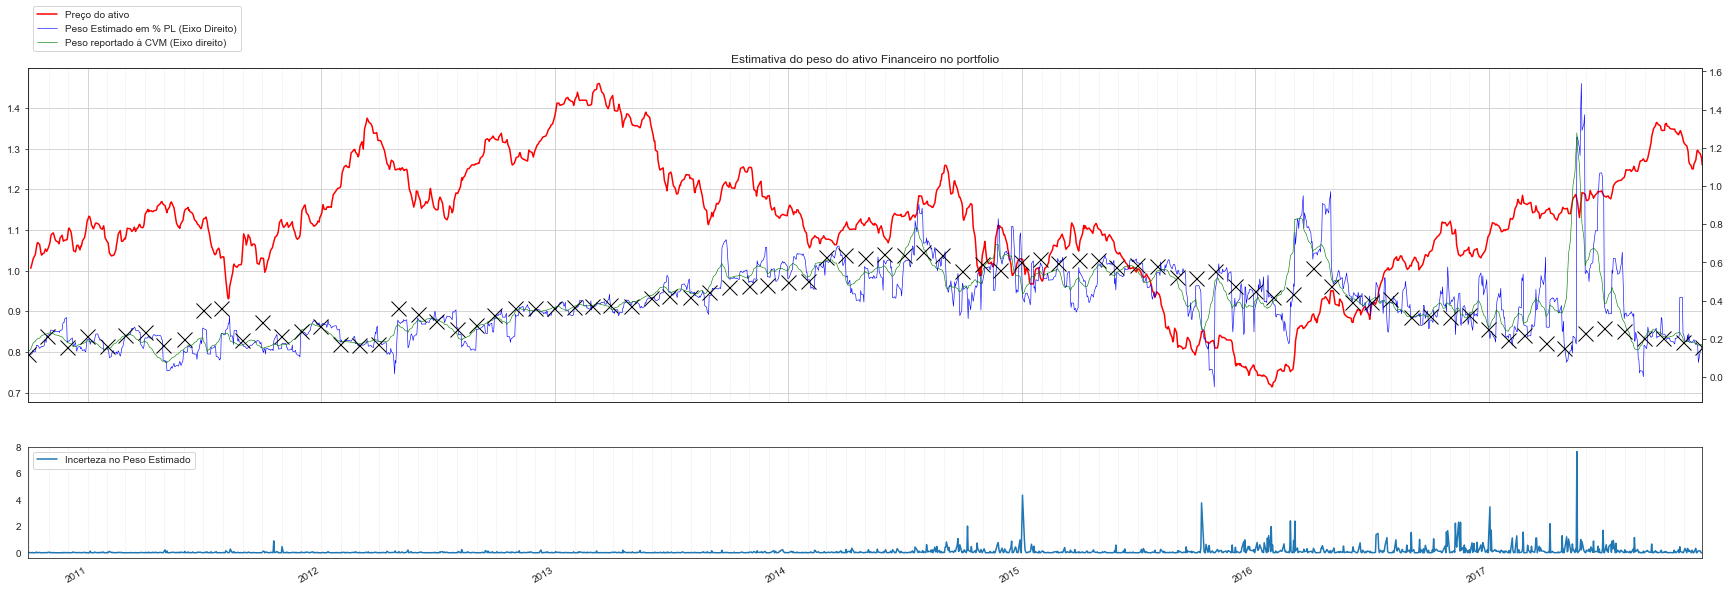

In [35]:
#verifica o ativo 
%matplotlib inline

ativo = 'Financeiro'


erro_estimativa_ativo = pd.Series(s.y[:,0], index=measurements.index).pow(2).div(s.S[:,0,0])


fig, ax = plt.subplots(2,1, figsize=(30,10), sharex=True, gridspec_kw=dict(height_ratios=[3,1], hspace=0.2), facecolor='white')
estimativas.loc[:,ativo].plot(secondary_y=True, color='Blue', legend='peso', ax=ax[0], lw=.6)
smooth.loc[:,ativo].plot(secondary_y=True, color='Green', legend='peso', ax=ax[0], lw=.6)
states[ativo].dropna().plot(marker='x', linestyle='', color='black', markersize='15', secondary_y=True, ax=ax[0])
signals.loc[:,ativo].rolling(3).median().add(1).cumprod().plot(color='red',ax=ax[0])



import matplotlib.dates as mdates

ax[0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[0].grid(which='major', linestyle='-')
ax[0].grid(which='minor', linestyle=':', lw=.5)

ax[1].xaxis.set_minor_locator( mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].grid(which='major', linestyle='-')
ax[1].grid(which='minor', linestyle=':', lw=.5)


erro_estimativa_ativo.plot(ax=ax[1])

[t.set_visible(True) for t in ax[0].get_xticklabels()]
ax[0].set_title("Estimativa do peso do ativo {} no portfolio".format(ativo))
handlers = ax[0].get_legend_handles_labels()[0] + ax[0].right_ax.get_legend_handles_labels()[0]
ax[0].legend(handlers, ["Preço do ativo", "Peso Estimado em % PL (Eixo Direito)","Peso reportado à CVM (Eixo direito)"], loc=2, bbox_to_anchor=(0,1.2))
ax[1].legend(ax[1].get_legend_handles_labels()[0], ["Incerteza no Peso Estimado"])

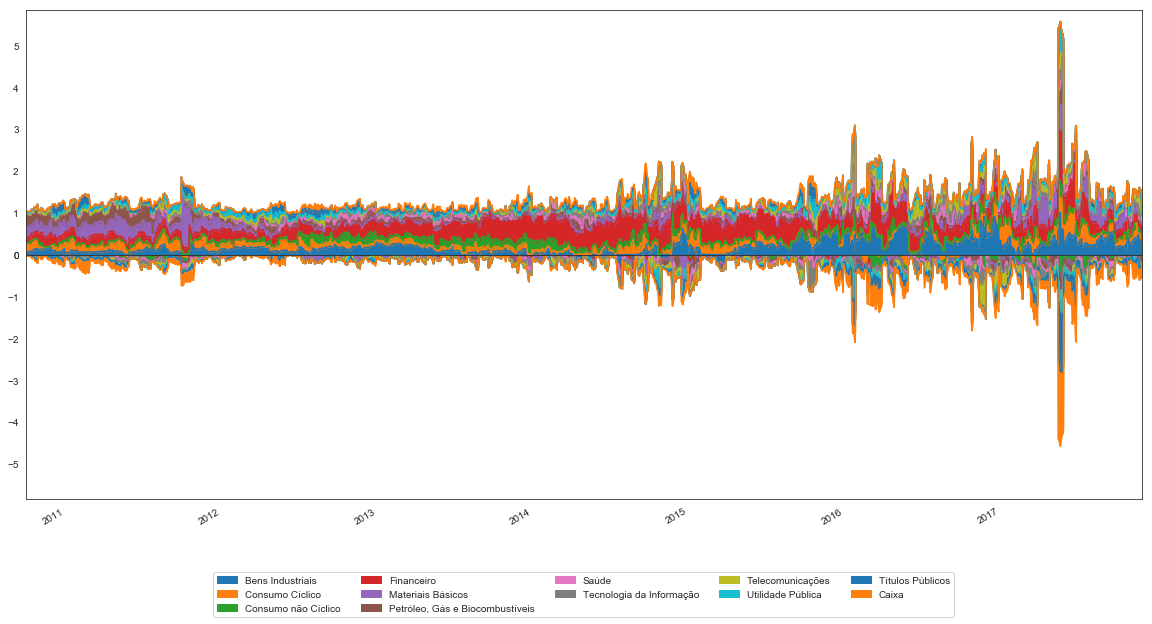

In [36]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
estimativas[(estimativas > 0)].reindex(columns=pesos_agregados.columns).plot.area(figsize=(20,10), ax=axu, legend=None)
estimativas[(estimativas < 0)].reindex(columns=pesos_agregados.columns).plot.area(figsize=(20,10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1],0)
axd.legend(ncol=5,loc=8, bbox_to_anchor=(0.5,-0.5))

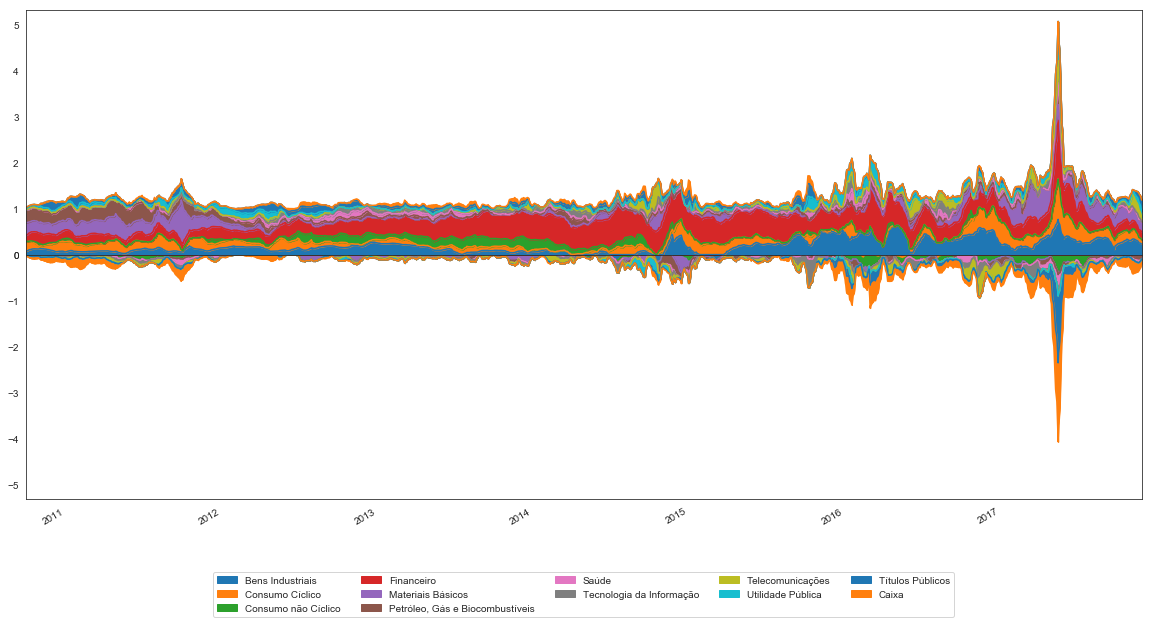

In [37]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
smooth[(smooth > 0)].reindex(columns=pesos_agregados.columns).plot.area(figsize=(20,10), ax=axu, legend=None)
smooth[(smooth < 0)].reindex(columns=pesos_agregados.columns).plot.area(figsize=(20,10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1],0)
axd.legend(ncol=5,loc=8, bbox_to_anchor=(0.5,-0.5))

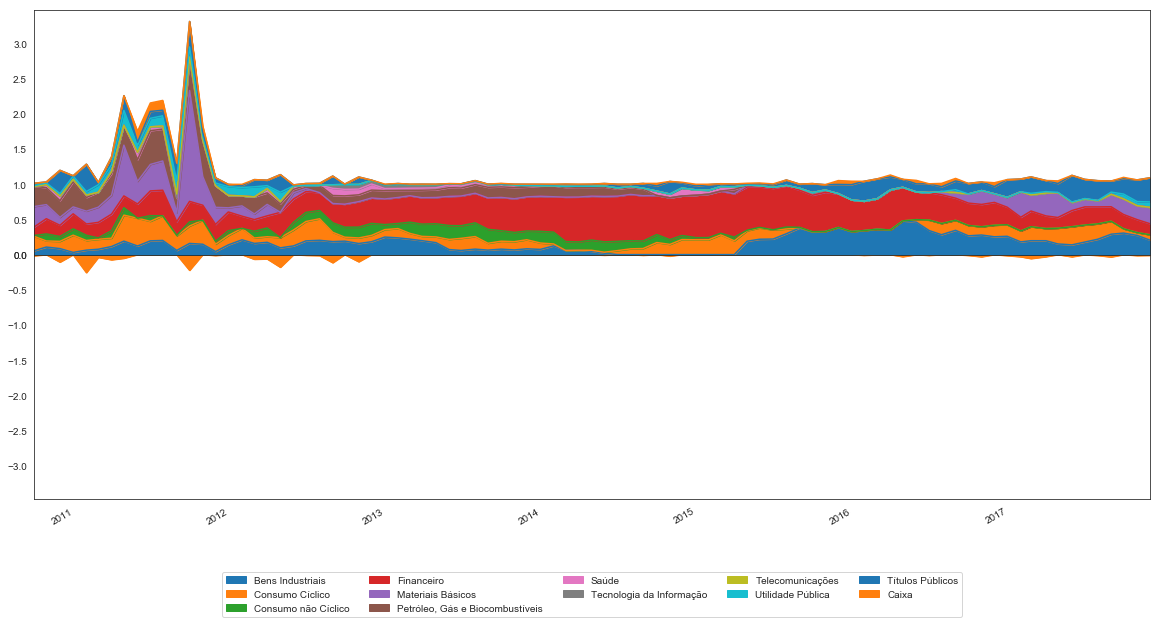

In [38]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
eom_pesos[(eom_pesos > 0)].reindex(columns=pesos_agregados.columns).plot.area(figsize=(20,10), ax=axu, legend=None)
eom_pesos[(eom_pesos < 0)].reindex(columns=pesos_agregados.columns).plot.area(figsize=(20,10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1],0)
axd.legend(ncol=5,loc=8, bbox_to_anchor=(0.5,-0.5))


Correlacao 0.9266956322174495


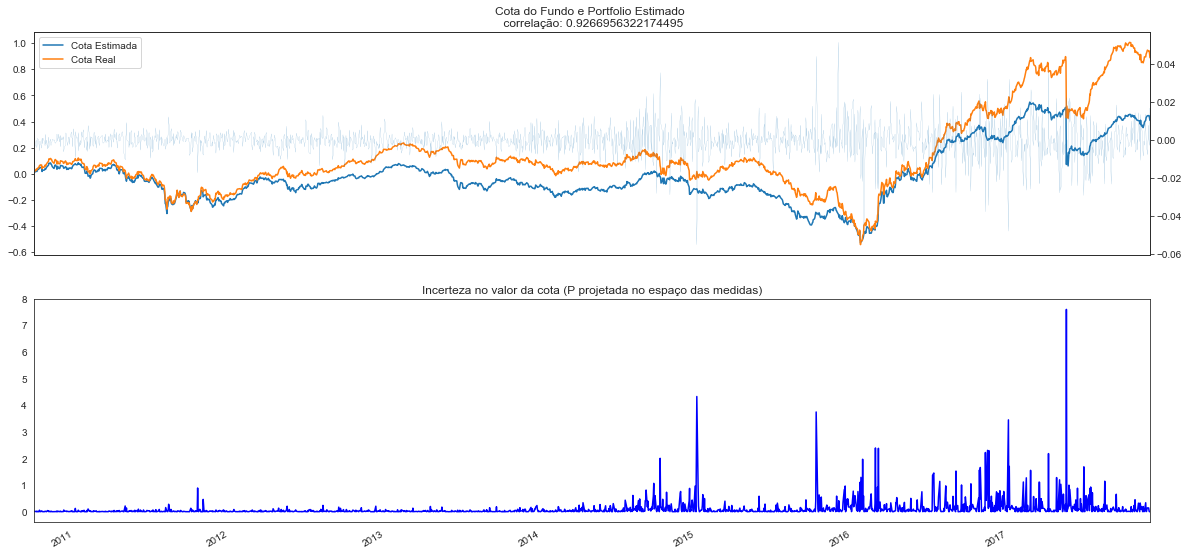

In [39]:
erros = pd.Series(s.y[:,0], index=measurements.index).pow(2).div(s.S[:,0,0])

fig, (axu, axd) = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True, facecolor='white')
estimativas.mul(signals).sum(1).cumsum().plot(ax=axu)
measurements.cumsum().plot(ax=axu)
axur = axu.twinx()
(estimativas.mul(signals).sum(1) - measurements.T).plot(ax=axur, lw='0.1')
erros.plot(color='Blue', secondary_y=False, ax=axd)
print("Correlacao", estimativas.mul(signals).sum(1).corr(measurements))
axu.set_title("Cota do Fundo e Portfolio Estimado \n correlação: {}".format(estimativas.mul(signals).sum(1).corr(measurements)))
axd.set_title("Incerteza no valor da cota (P projetada no espaço das medidas)")
axu.legend(['Cota Estimada','Cota Real'])

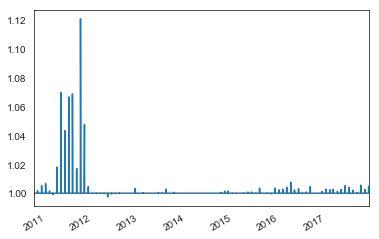

In [40]:
estimativas.sum(axis=1).plot()

## Kalman por setor

In [41]:
cota_setor = estimativas * signals
setor = 'Financeiro'


In [42]:
estimations_2step = []
for setor in tqdm.tqdm_notebook(pesos_acoes.columns):
    measurements_setor = cota_setor[setor]
    pesos_setor = pesos.groupby(classes_acoes.get, axis=1).get_group(setor)
    signals_setor = retornos_acoes_empresa.reindex(columns=pesos_setor.columns).reindex(index=measurements_setor.index)

    eom_pesos_setor = pesos_setor.resample('D').bfill().reindex(index=measurements_setor.index).reindex(index=measurements_setor.groupby(pd.Grouper(freq='M')).tail(1).index)
    states_setor = eom_pesos_setor.reindex(columns=signals_setor.columns, index=measurements_setor.index)

    #Tratamento de outliers
    q = signals_setor < signals_setor.std()*3
    signals_setor = signals_setor[q].fillna(signals_setor.rolling(3, center=True).median())

    #correlação de não se fazer nada
    states_setor.fillna(method='pad').mul(signals_setor).sum(axis=1).corr(measurements_setor)

    n_dim = len(states_setor.columns)

    from filterpy.kalman import KalmanFilter
    from filterpy.common import Saver, inv_diagonal
    import tqdm

    kf = KalmanFilter(n_dim,1+ n_dim)
    kf.F *= 1
    kf.Q *= np.sqrt(0.005/10)#0.31#2500


    kf.x = eom_pesos_setor.iloc[0].fillna(0).values
    kf.P = np.zeros(kf.dim_x)


    s = Saver(kf)
    Hs = []
    Rs = []
    Zs = []
    for i,dt in tqdm.tqdm_notebook(enumerate(measurements.index), total=len(measurements), leave=False):

        if dt in eom_pesos_setor.index:
            H = np.vstack([signals_setor.loc[dt].fillna(0).values.reshape(1,kf.dim_x), np.eye(kf.dim_x)])
            R = np.eye(kf.dim_z) * 0.3 /10
        else:
            H = np.vstack([signals_setor.loc[dt].fillna(0).values.reshape(1,kf.dim_x),  np.eye(kf.dim_x)*0]).astype(float)
            R = np.eye(kf.dim_z) * 0.3
        R[0,0] = 0.0008
            #R[-1,-1] = 0.00000001


        Z = np.hstack([measurements_setor.loc[dt], states_setor.loc[dt].fillna(0)])

        kf.H = H
        kf.R = R
        #kf.F = np.diag((1-H[0]).reshape(kf.dim_x))

        kf.predict()
        kf.update(Z)

        s.save()

    s.to_array()

    estimativas_setor = pd.DataFrame(s.x, index=measurements_setor.index, columns=signals_setor.columns)
    (estimativas_setor * signals_setor).sum(axis=1).corr(measurements_setor)

    from filterpy.kalman import rts_smoother
    ## Calcula as matrizes smoothed
    sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

    smooth_setor = pd.DataFrame(sx, index=measurements_setor.index, columns=signals_setor.columns)
    (smooth_setor * signals_setor).sum(axis=1).corr(measurements_setor)
    estimations_2step.append(smooth_setor)

In [43]:
result = pd.concat(estimations_2step, axis=1)
result = result.loc[:,~result.columns.duplicated()]
result = pd.concat([result, smooth.iloc[:,-2:]], axis=1)

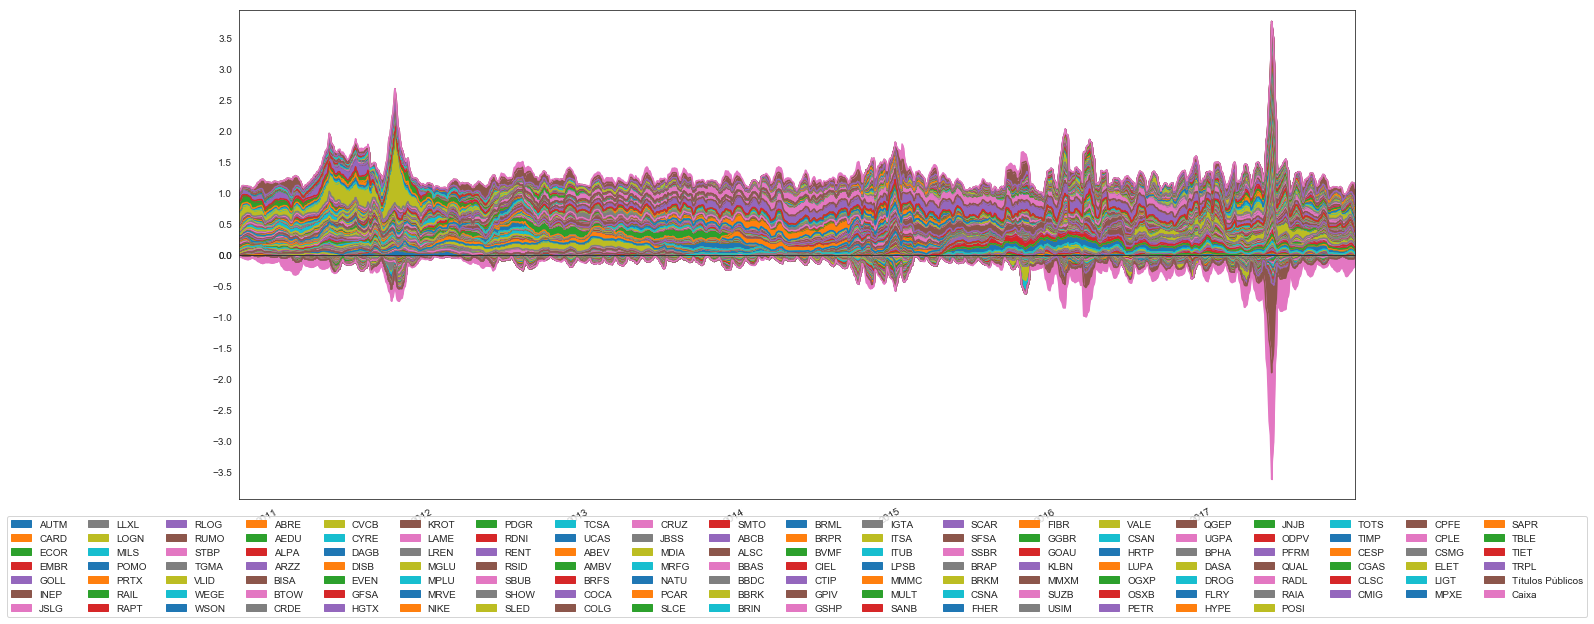

In [44]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
result[(result > 0)].plot.area(figsize=(20,10), ax=axu, legend=None)
result[(result < 0)].plot.area(figsize=(20,10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1],0)
axd.legend(ncol=20,loc=8, bbox_to_anchor=(0.5,-0.5))

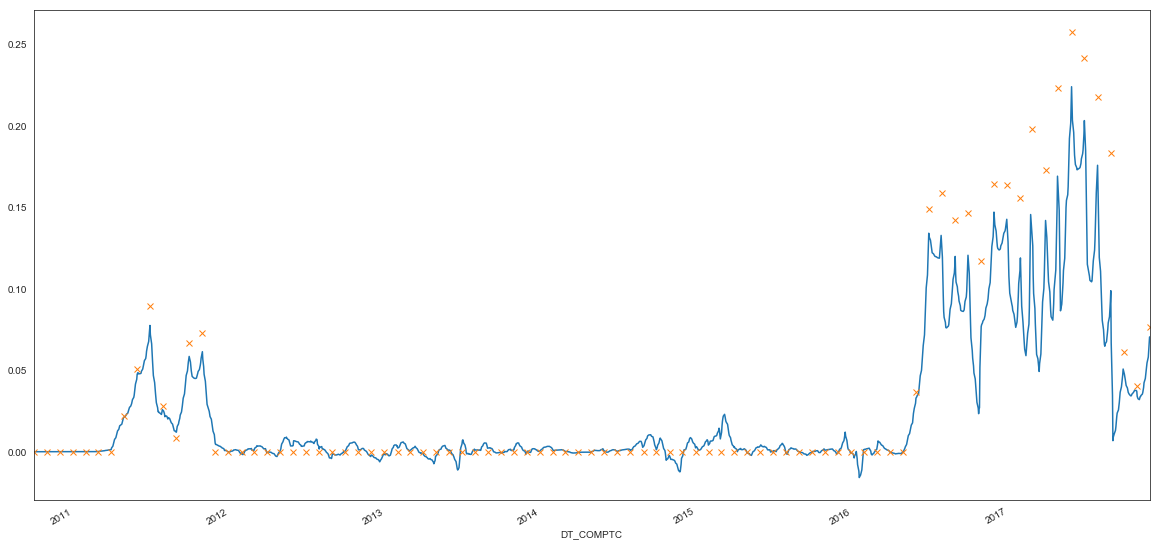

In [45]:
result['MGLU'].plot(figsize=(20,10))
pesos['MGLU'].plot(ls=' ', marker='x')